<a href="https://colab.research.google.com/github/Tanainan/Covid-19Thailand/blob/main/ML_multivariate_cases_%2B_deaths.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-19 Trends Prediction in Thailand Using Time Series Machine Learning
---


We trained linear regression, ridge regression, lasso, and elastic net to predict Covid-19 cases and deaths in Thailand. We used previous 14 days data  to predict the next 1 day, including COVID-19 cases, Google mobility data, Apple mobility data. These models particularly deal with time series data.  Our goal was to minimize the mean average percentage error (MAPE) between the actual values and predictions.  



## Data Sources


The Covid-19 data was from https://github.com/CSSEGISandData/COVID-19 by John Hopkins University. The data included both daily confirmed infects and daily confirmed deaths reported by Thailand’s Ministry of Public Health. 

The mobility data was from Google (https://www.google.com/covid19/mobility). Google calculated the changes of mobility based on Location History of users on Google Map. The baseline of the changes was the median value from January, 3rd to February 6th, 2020. There were four categories: groceries and pharmacy, retail and recreation, transit stations, and finally, parks. Another source of mobility was from Apple where it tracked driving and walking behaviors during the pandemic (https://covid19.apple.com/mobility). 




## Import packages

In [ ]:
!pip install -U tensorflow-addons
from numpy import hstack
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import pandas as pd
import numpy as np
from statistics import stdev
from statistics import mean
from matplotlib import pyplot
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)
from matplotlib import pyplot as plt
import datetime as dt
import matplotlib.ticker as ticker
import plotly.graph_objects as go
from statsmodels.graphics.factorplots import interaction_plot
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_rows', None)
import itertools
!pip install -U scikit-learn
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.utils import to_categorical
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf
from warnings import simplefilter
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

     |████████████████████████████████| 1.1 MB 7.6 MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


### Data

---

The first feature was Google community mobility. The data was collected based on places visits. This included retail and recreation; grocery and pharmacy; parks; transit stations; workplaces; residential. The second feature was Apple mobilities -- driving and walking. All predictors were merged into inputs for predicting cases (data_i) and deaths (data_d).

In [ ]:
mob = read_csv("https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv")

mob = pd.DataFrame(mob)

# select only Thailand
mob = mob.loc[mob['country_region'] == "Thailand"]

# select columns
mob = mob[["date",
              "retail_and_recreation_percent_change_from_baseline",
              "grocery_and_pharmacy_percent_change_from_baseline",
              "parks_percent_change_from_baseline",
              "transit_stations_percent_change_from_baseline",
              "workplaces_percent_change_from_baseline",
              "residential_percent_change_from_baseline"]]

# change date format
mob.date =  pd.to_datetime(mob["date"])

# change column name
mob = mob.rename(columns = {'date':'Date',
                            "retail_and_recreation_percent_change_from_baseline":'retail',
                            "grocery_and_pharmacy_percent_change_from_baseline": "grocery",
                            "parks_percent_change_from_baseline":'parks',
                            "transit_stations_percent_change_from_baseline":"transit",
                            "workplaces_percent_change_from_baseline":"workplace",
                            "residential_percent_change_from_baseline":"resident"})

# reset index
mob = mob.reset_index(drop = True)

# start from 15/6/2021
mob = mob[mob.loc[mob['Date'] == "2021-06-15"].index[0]:]

# reset index
mob = mob.reset_index(drop = True)

# omit Date column
mob = mob.drop(["Date"], axis = 1)

In [ ]:
apple = read_csv("https://raw.githubusercontent.com/ActiveConclusion/COVID19_mobility/master/apple_reports/applemobilitytrends.csv")

apple = pd.DataFrame(apple)

apple = apple.loc[apple['region'] == "Thailand"]

apple = apple.T

# select rows
apple = apple.drop(apple.index[[0,1,2,3,4,5]], axis= 0)

apple["Date"] = pd.to_datetime(apple.index)

# change column names
apple = apple.rename(columns= {135:"Driving", 136:"Walking"})

apple['Driving'] = apple['Driving'].astype(float, errors = 'raise')
apple['Walking'] = apple['Walking'].astype(float, errors = 'raise')

# start from 15/6/2021
apple = apple[apple.loc[apple['Date'] == "2021-06-15"].index[0]:]

apple = apple.reset_index(drop=True)

# omit Date column
apple0 = apple.drop(["Date"], axis = 1)

In [ ]:
data1 = read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/jhu/new_cases.csv")

data1 = pd.DataFrame(data1)

# select columns
data1 = data1[["date", "Thailand"]]

# change column name
data1 = data1.rename(columns = {'date':'Date', 'Thailand':'Cases_daily'})

# # change date format
data1.Date =  pd.to_datetime(data1["Date"])

# replace NaN with 0 for ConfirmedCases and ConfirmedDeaths
data1[["Cases_daily"]] = data1[["Cases_daily"]].replace(np.nan, 0)

# start from 15/6/2021
data1 = data1[data1.loc[data1['Date'] == "2021-06-15"].index[0]:]

# reset index
data_i = data1.reset_index(drop = True)

# whichever has fewer data
length = min(len(data1), len(mob), len(apple0))

# Cases daily
data_i = pd.concat([data_i.Cases_daily[:length], 
                    data_i.Date[:length],
                    apple0[:length],
                    mob[:length]], axis = 1)

# data_i = data_i.rename(columns = {"Cases_daily":"data_i"})
# data_i = data_i[data_i.loc[data_i['Date'] == "2021-06-15"].index[0]:]

infect = data_i.Cases_daily

In [ ]:
data2 = read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/jhu/new_deaths.csv")

data2 = pd.DataFrame(data2)

# select columns
data2 = data2[["date", "Thailand"]]

# change column name
data2 = data2.rename(columns = {'date':'Date', 'Thailand':'Deaths_daily'})

# # change date format
data2.Date =  pd.to_datetime(data2["Date"])

# replace NaN with 0 for ConfirmedCases and ConfirmedDeaths
data2[["Deaths_daily"]] = data2[["Deaths_daily"]].replace(np.nan, 0)

# start from 15/6/2021
data2 = data2[data2.loc[data2['Date'] == "2021-06-15"].index[0]:]

# reset index
data_d = data2.reset_index(drop = True)

# whichever has fewer data
length = min(len(data2), len(mob), len(apple0))

# Deaths daily
data_d = pd.concat([data_d.Deaths_daily[:length], 
                    data_d.Date[:length],
                    apple0[:length],
                    mob[:length]], axis = 1)

# data_d = data_d.rename(columns = {"Cases_daily":"data_i"})
# data_d = data_d[data_d.loc[data_d['Date'] == "2021-06-15"].index[0]:]

death = data_d.Deaths_daily

Since there were some noises, we used moving average with a window of 3 days to reduce the noises.

In [ ]:
window = 3 # for moving average

lag = 14
index = 30
prediction = 1

# moving average
data_i['Cases_daily'] = data_i.Cases_daily.rolling(window).mean()

data_d['Deaths_daily'] = data_d.Deaths_daily.rolling(window).mean()


# remove NaN
data_i.dropna(subset = ["Cases_daily"], inplace=True)
data_d.dropna(subset = ["Deaths_daily"], inplace=True)

data_i = data_i.reset_index(drop = True)
data_d = data_d.reset_index(drop = True)

data_i = data_i.drop(["Date"], axis = 1)
data_d = data_d.drop(["Date"], axis = 1)

## Methods

---


The data was available from February 22nd, 2020 to present date. However, the third wave of the epidemic in Thailand started after April 1st, 2021, and the trend started to go upward after June. Thus, we used the data from, June 15th to July 29th, 2021 for our training. There were 30 samples in total for training. Days being predicted were all 14 days before the present date.


For the multivariate, we created an input with 14 columns as the previous 14 days input for all features -- cases and mobilities. The number of rows was equal to total samples - 14 days - 1-day prediction + 1. To demonstrate, the first row would have the 1st to the 14th day. The second row would have the 2nd to the 15th day, and so forth as a rolling window. The output would be the 1 column for 1-day prediction with the same amount of rows as the input. For example, the first output row would be the 15th day for the 1-day prediction.

In general, we trained models using linear regression, ridge regression, lasso, and elastic net and obtained the most optimal coefficient values. This process was experimented with the training data set. This data set was the first 30 rows of our input. The rest of the rows were the test set. Selected models were later used for predictions with test data set. In each model, we showed the predicted and actual values in a graph. The blue line indicated prediction coming from training set, and the red line was the test set. Note that the gray line represented the moving average of the actual values. We also reported MAPE of the test prediction.

# Linear Regression

## Cases

MAPE = 1.4364277967656134e+17


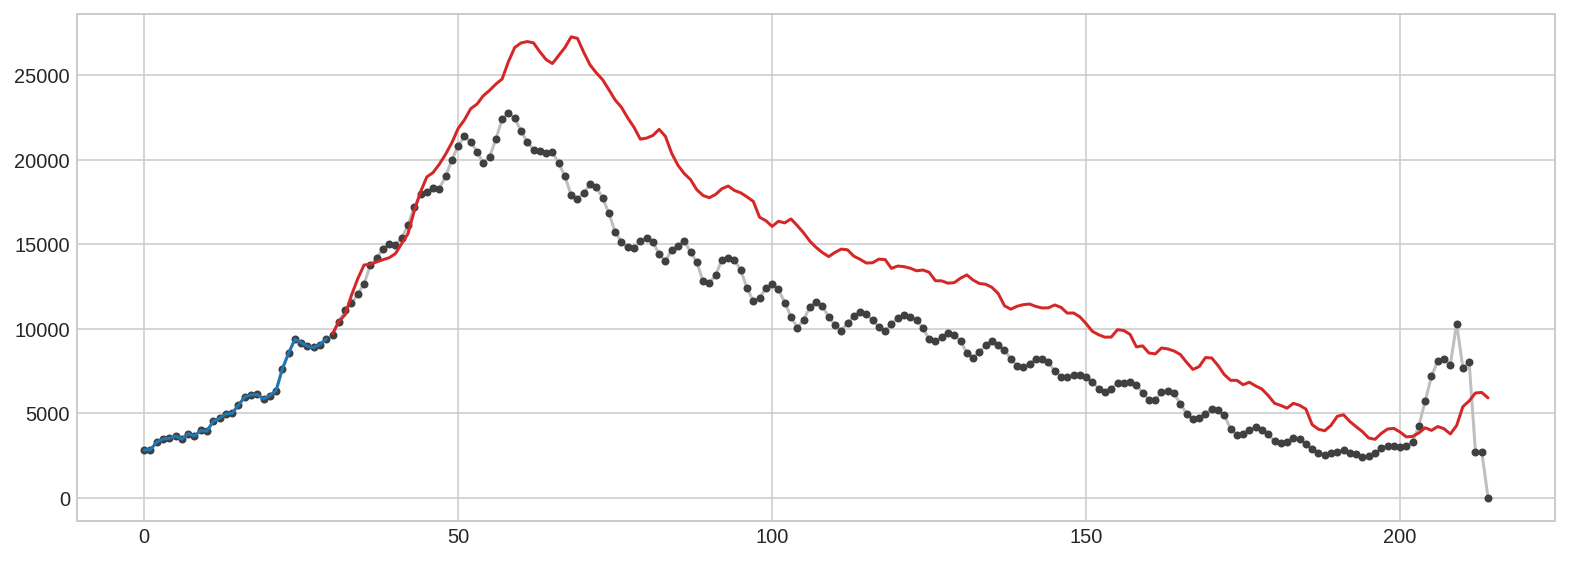

In [ ]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


X_i = make_lags(data_i, lags=14)
X_i = X_i.fillna(0.0)

# Create target series and data splits
y_i = data_i.Cases_daily.copy()
X_i_train, X_i_test, y_i_train, y_i_test = train_test_split(X_i, y_i, train_size=30, shuffle=False)

model_lr_i = LinearRegression() 
model_lr_i.fit(X_i_train, y_i_train)
y_pred_lr_i = pd.Series(model_lr_i.predict(X_i_train), index=y_i_train.index)
y_fore_lr_i = pd.Series(model_lr_i.predict(X_i_test), index=y_i_test.index)
y_total_lr_i = pd.concat([y_pred_lr_i, y_fore_lr_i])

mape_lr_i = mean_absolute_percentage_error(y_i_test, y_fore_lr_i)

print("MAPE =", mape_lr_i)

ax = y_i_train.plot(**plot_params)
ax = y_i_test.plot(**plot_params)
ax = y_pred_lr_i.plot(ax=ax)
_ = y_fore_lr_i.plot(ax=ax, color='C3')

## Deaths

MAPE = 0.19635113876080715


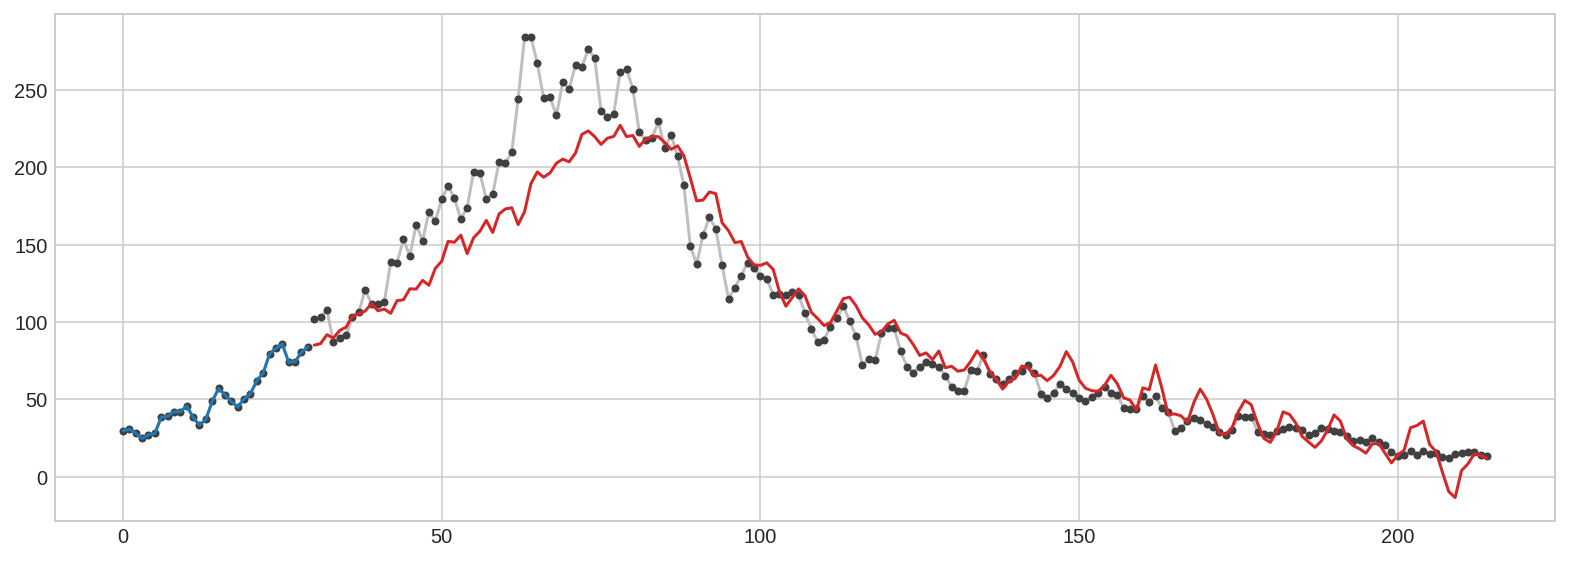

In [ ]:
X_d = make_lags(data_d, lags=14)
X_d = X_d.fillna(0.0)

# Create target series and data splits
y_d = data_d.Deaths_daily.copy()
X_d_train, X_d_test, y_d_train, y_d_test = train_test_split(X_d, y_d, train_size=30, shuffle=False)

model_lr_d = LinearRegression() 
model_lr_d.fit(X_d_train, y_d_train)
y_pred_lr_d = pd.Series(model_lr_d.predict(X_d_train), index=y_d_train.index)
y_fore_lr_d = pd.Series(model_lr_d.predict(X_d_test), index=y_d_test.index)
y_total_lr_d = pd.concat([y_pred_lr_d, y_fore_lr_d])

mape_lr_d = mean_absolute_percentage_error(y_d_test, y_fore_lr_d)

print("MAPE =", mape_lr_d)


ax = y_d_train.plot(**plot_params)
ax = y_d_test.plot(**plot_params)
ax = y_pred_lr_d.plot(ax=ax)
_ = y_fore_lr_d.plot(ax=ax, color='C3')

# Ridge Regression

## Cases

MAPE = 1.4361859718118485e+17


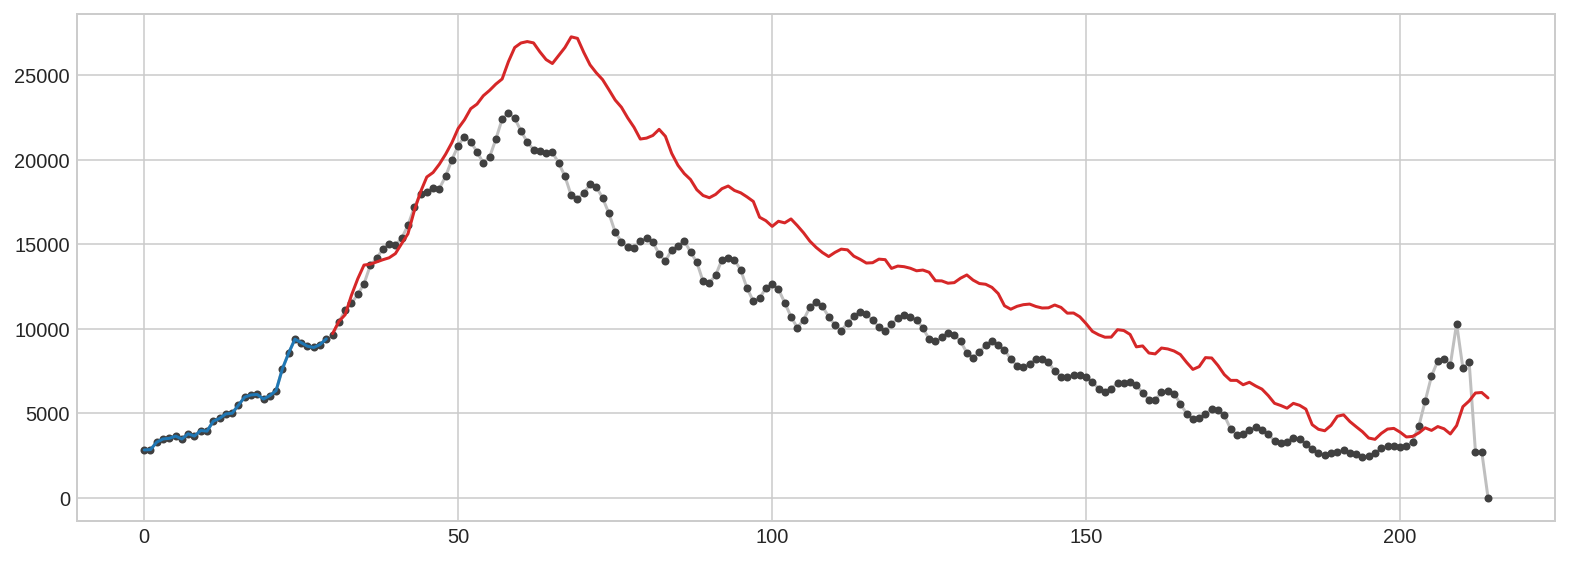

In [ ]:
model_rr_i = Ridge() 
model_rr_i.fit(X_i_train, y_i_train)
y_pred_rr_i = pd.Series(model_rr_i.predict(X_i_train), index=y_i_train.index)
y_fore_rr_i = pd.Series(model_rr_i.predict(X_i_test), index=y_i_test.index)
y_total_rr_i = pd.concat([y_pred_rr_i, y_fore_rr_i])

mape_rr_i = mean_absolute_percentage_error(y_i_test, y_fore_rr_i)

print("MAPE =", mape_rr_i)

ax = y_i_train.plot(**plot_params)
ax = y_i_test.plot(**plot_params)
ax = y_pred_rr_i.plot(ax=ax)
_ = y_fore_rr_i.plot(ax=ax, color='C3')

## Deaths

MAPE = 0.1962531476860042


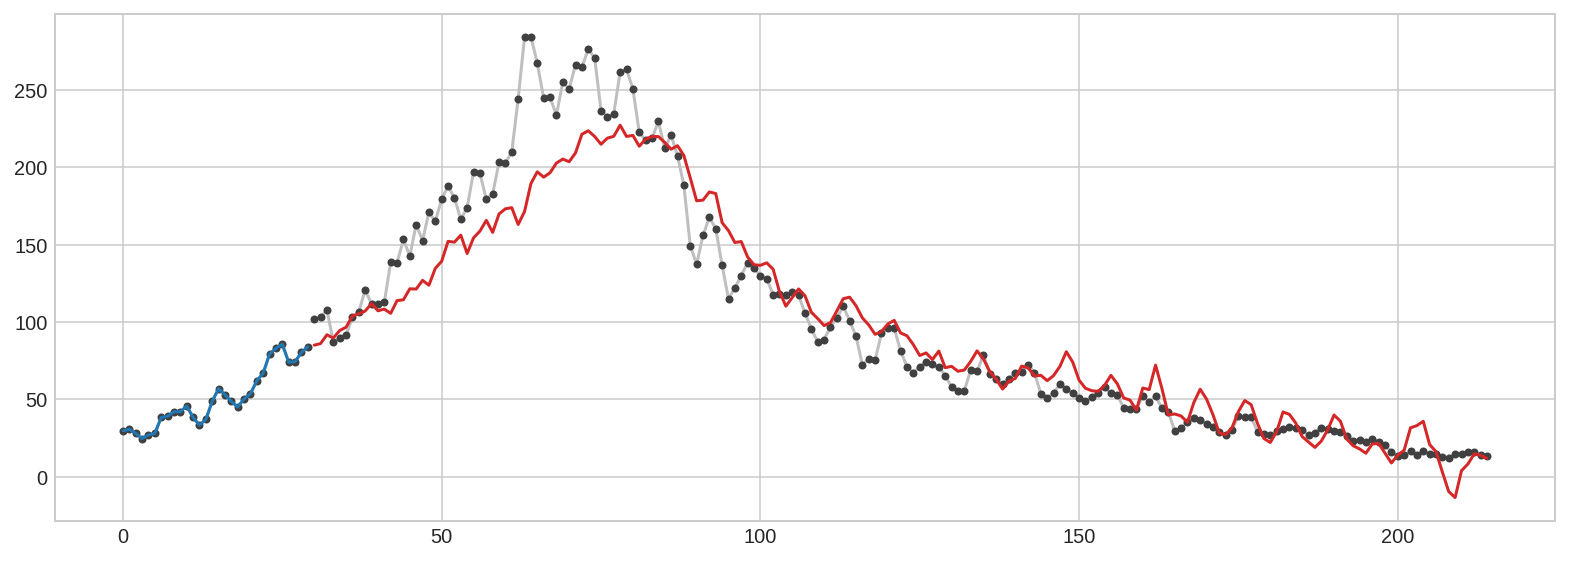

In [ ]:

model_rr_d = Ridge()
model_rr_d.fit(X_d_train, y_d_train)
y_pred_rr_d = pd.Series(model_rr_d.predict(X_d_train), index=y_d_train.index)
y_fore_rr_d = pd.Series(model_rr_d.predict(X_d_test), index=y_d_test.index)
y_total_rr_d = pd.concat([y_pred_rr_d, y_fore_rr_d])

mape_rr_d = mean_absolute_percentage_error(y_d_test, y_fore_rr_d)

print("MAPE =", mape_rr_d)


ax = y_d_train.plot(**plot_params)
ax = y_d_test.plot(**plot_params)
ax = y_pred_rr_d.plot(ax=ax)
_ = y_fore_rr_d.plot(ax=ax, color='C3')

# Lasso Regression

## Cases

MAPE = 8.879044245998954e+16


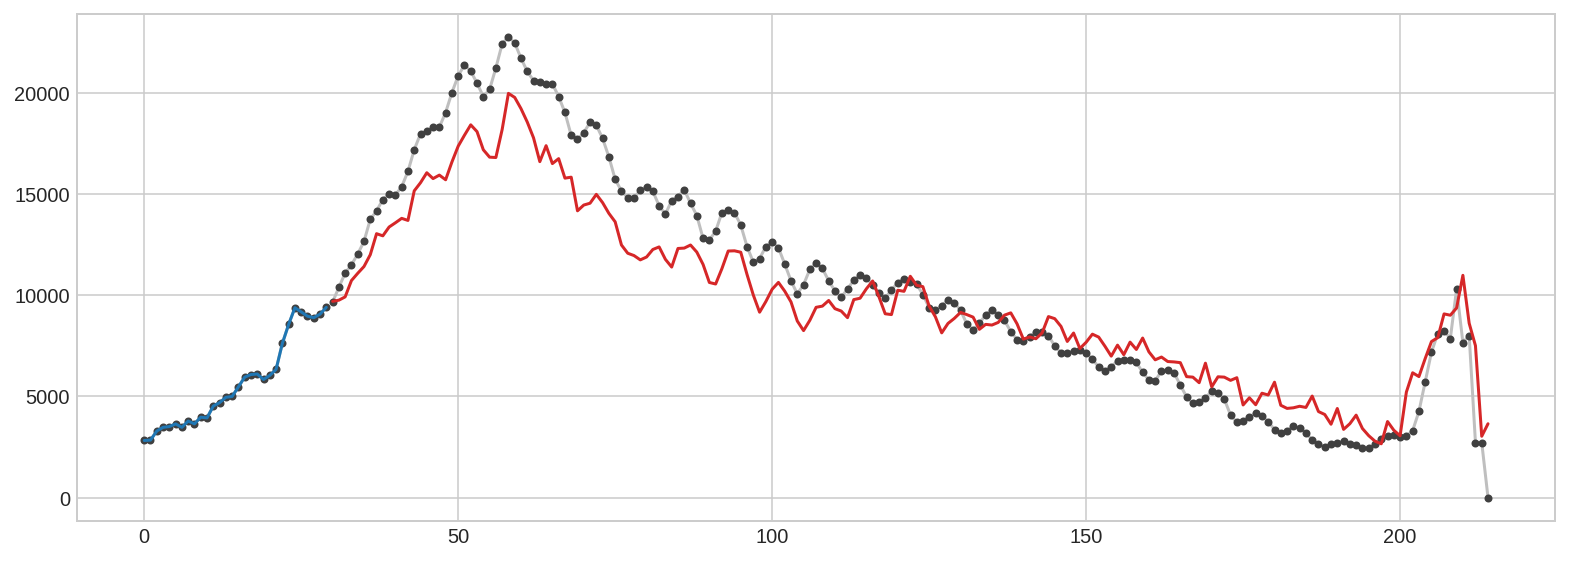

In [ ]:
model_ls_i = Lasso(alpha = 0.1) 
model_ls_i.fit(X_i_train, y_i_train)
y_pred_ls_i = pd.Series(model_ls_i.predict(X_i_train), index=y_i_train.index)
y_fore_ls_i = pd.Series(model_ls_i.predict(X_i_test), index=y_i_test.index)
y_total_ls_i = pd.concat([y_pred_ls_i, y_fore_ls_i])

mape_ls_i = mean_absolute_percentage_error(y_i_test, y_fore_ls_i)

print("MAPE =", mape_ls_i)

ax = y_i_train.plot(**plot_params)
ax = y_i_test.plot(**plot_params)
ax = y_pred_ls_i.plot(ax=ax)
_ = y_fore_ls_i.plot(ax=ax, color='C3')

## Deaths

MAPE = 0.18516405752370763


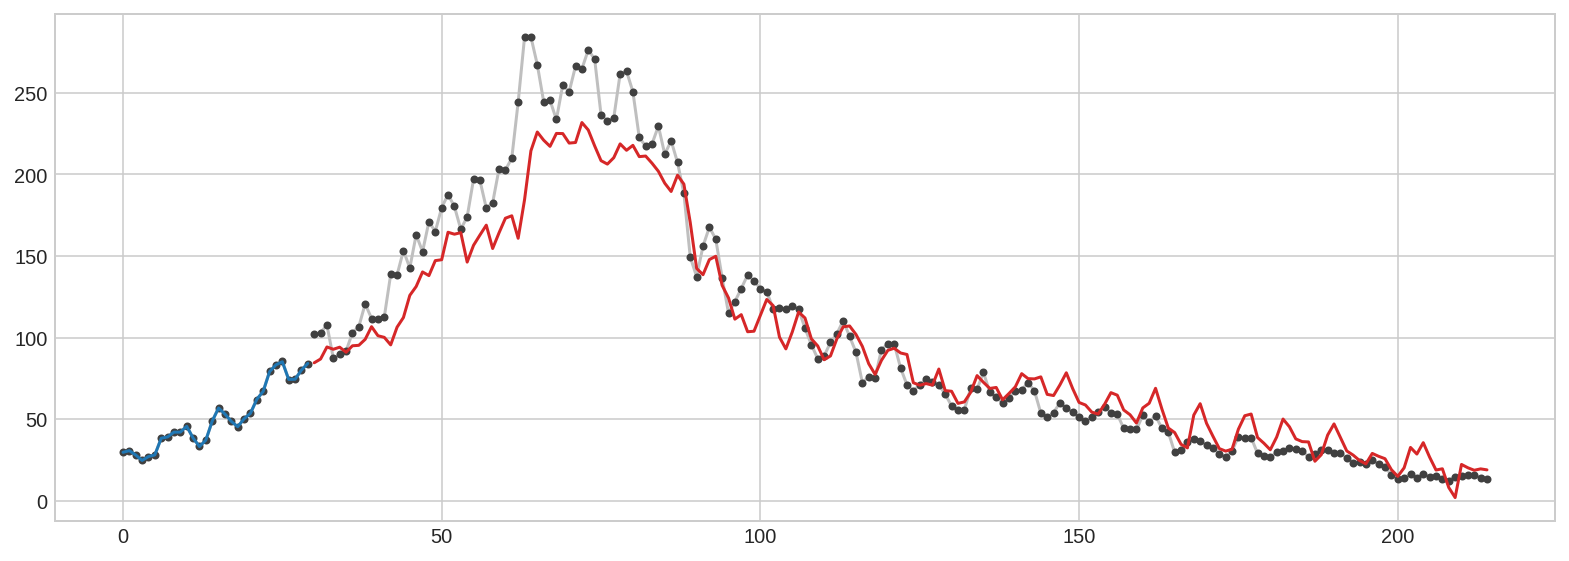

In [ ]:

model_ls_d = Lasso(alpha = 0.1)
model_ls_d.fit(X_d_train, y_d_train)
y_pred_ls_d = pd.Series(model_ls_d.predict(X_d_train), index=y_d_train.index)
y_fore_ls_d = pd.Series(model_ls_d.predict(X_d_test), index=y_d_test.index)
y_total_ls_d = pd.concat([y_pred_ls_d, y_fore_ls_d])

mape_ls_d = mean_absolute_percentage_error(y_d_test, y_fore_ls_d)

print("MAPE =", mape_ls_d)


ax = y_d_train.plot(**plot_params)
ax = y_d_test.plot(**plot_params)
ax = y_pred_ls_d.plot(ax=ax)
_ = y_fore_ls_d.plot(ax=ax, color='C3')

# Elastic Net

## Cases

MAPE = 7.804730924887162e+16


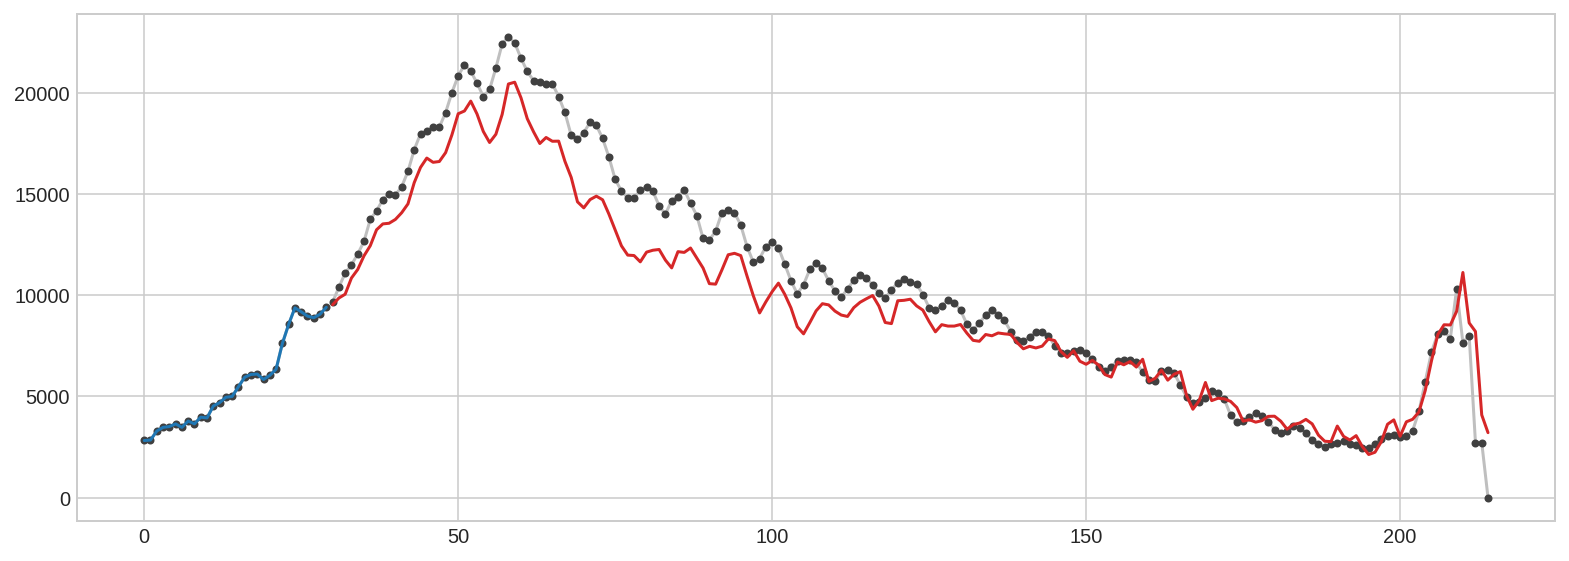

In [ ]:
model_en_i = ElasticNet(alpha=0.5)
model_en_i.fit(X_i_train, y_i_train)
y_pred_en_i = pd.Series(model_en_i.predict(X_i_train), index=y_i_train.index)
y_fore_en_i = pd.Series(model_en_i.predict(X_i_test), index=y_i_test.index)
y_total_en_i = pd.concat([y_pred_en_i, y_fore_en_i])

mape_en_i = mean_absolute_percentage_error(y_i_test, y_fore_en_i)


print("MAPE =", mape_en_i)


ax = y_i_train.plot(**plot_params)
ax = y_i_test.plot(**plot_params)
ax = y_pred_en_i.plot(ax=ax)
_ = y_fore_en_i.plot(ax=ax, color='C3')

## Deaths

MAPE = 0.5023517229846681


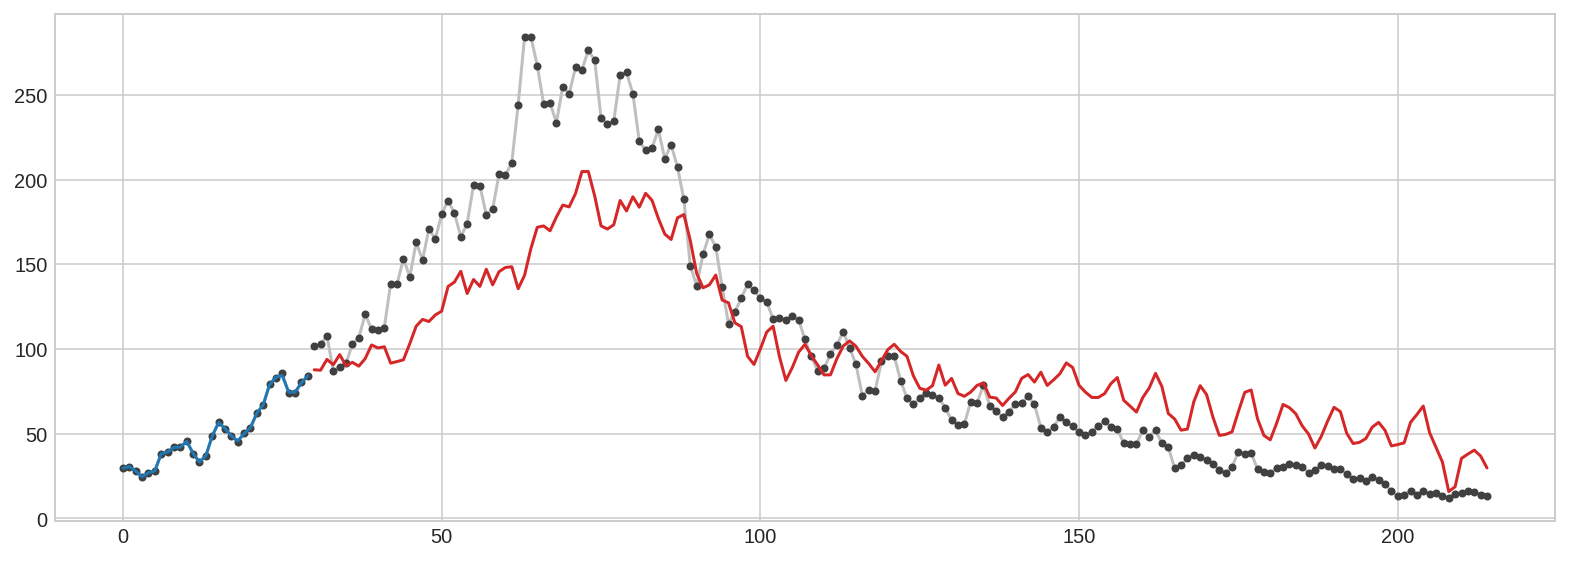

In [ ]:
model_en_d = ElasticNet(alpha = 0.5)
model_en_d.fit(X_d_train, y_d_train)
y_pred_en_d = pd.Series(model_en_d.predict(X_d_train), index=y_d_train.index)
y_fore_en_d = pd.Series(model_en_d.predict(X_d_test), index=y_d_test.index)
y_total_en_d = pd.concat([y_pred_en_d, y_fore_en_d])

mape_en_d = mean_absolute_percentage_error(y_d_test, y_fore_en_d)

print("MAPE =", mape_en_d)


ax = y_d_train.plot(**plot_params)
ax = y_d_test.plot(**plot_params)
ax = y_pred_en_d.plot(ax=ax)
_ = y_fore_en_d.plot(ax=ax, color='C3')

# Result Table

## Cases

In [ ]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Test MAPE'],
                                           line_color = 'gray'),
                               cells=dict(values=[['Linear Regression', 
                                                   'Ridge Regression',
                                                   'Lasso Regression',
                                                   'Elastic Net'],
                                                  [round(mape_lr_i,4), round(mape_rr_i,4), round(mape_lr_i,4), round(mape_en_i,4)]],
                            align=['left','center', 'center'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Mean Absolute Percentage Error: Confirmed Cases",title_x=0.5)
fig.show()

## Deaths

In [ ]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Test MAPE'],
                                           line_color = 'gray'),
                               cells=dict(values=[['Linear Regression', 
                                                   'Ridge Regression',
                                                   'Lasso Regression',
                                                   'Elastic Net'],
                                                  [round(mape_lr_d,4), round(mape_rr_d,4), round(mape_lr_d,4), round(mape_en_d,4)]],
                            align=['left','center', 'center'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Mean Absolute Percentage Error: Confirmed Deaths",title_x=0.5)
fig.show()

# Future Predictions

---

In multivariate, we used predicted values as new input for future predictions. Since we predicted 14 days ahead, each of the day required 14 previous days as input. For example, the 2nd predicted day would use actual data of previous 13 days and 1 predicted data from the 1st predicted day. We used the same linear regression, ridge regression, lasso, and elastic net models for confirmed cases and confirmed deaths future predictions, respectively. Further, other features were included as inputs. Although, we did not have information about future trends of these features, we used the same models to predict these features first, then used these predicted features to predict the cases.


We created an input for each feature by making lags of previous 14 days of the feature.

In [ ]:
# retail
x_retail = make_lags(mob.retail, lags = lag)
x_retail = x_retail.fillna(0.0)
y_retail = mob.retail.copy()

X_tr_retail, X_ts_retail, y_tr_retail, y_ts_retail = train_test_split(x_retail, y_retail, train_size=30, shuffle=False)

# grocery
x_grocery = make_lags(mob.grocery, lags = lag)
x_grocery = x_grocery.fillna(0.0)
y_grocery = mob.grocery.copy()

X_tr_grocery, X_ts_grocery, y_tr_grocery, y_ts_grocery = train_test_split(x_grocery, y_grocery, train_size=30, shuffle=False)

# parks
x_parks = make_lags(mob.parks, lags = lag)
x_parks = x_parks.fillna(0.0)
y_parks = mob.parks.copy()

X_tr_parks, X_ts_parks, y_tr_parks, y_ts_parks = train_test_split(x_parks, y_parks, train_size=30, shuffle=False)

# transit
x_transit = make_lags(mob.transit, lags = lag)
x_transit = x_transit.fillna(0.0)
y_transit = mob.transit.copy()

X_tr_transit, X_ts_transit, y_tr_transit, y_ts_transit = train_test_split(x_transit, y_transit, train_size=30, shuffle=False) 


# workplace
x_workplace = make_lags(mob.workplace, lags = lag)
x_workplace = x_workplace.fillna(0.0)
y_workplace = mob.workplace.copy()

X_tr_workplace, X_ts_workplace, y_tr_workplace, y_ts_workplace = train_test_split(x_workplace, y_workplace, train_size=30, shuffle=False)


# resident
x_resident = make_lags(mob.resident, lags = lag)
x_resident = x_resident.fillna(0.0)
y_resident = mob.resident.copy()

X_tr_resident, X_ts_resident, y_tr_resident, y_ts_resident = train_test_split(x_resident, y_resident, train_size=30, shuffle=False)


# Driving 
x_Driving = make_lags(apple.Driving, lags = lag)
x_Driving = x_Driving.fillna(0.0)
y_Driving = apple.Driving.copy()

X_tr_Driving, X_ts_Driving, y_tr_Driving, y_ts_Driving = train_test_split(x_Driving, y_Driving, train_size=30, shuffle=False)

# Walking
x_Walking = make_lags(apple.Walking, lags = lag)
x_Walking = x_Walking.fillna(0.0)
y_Walking = apple.Walking.copy()

X_tr_Walking, X_ts_Walking, y_tr_Walking, y_ts_Walking = train_test_split(x_Walking, y_Walking, train_size=30, shuffle=False)

Next, we trained models for each feature.

In [ ]:
# train model for Driving
seed(1)
tensorflow.random.set_seed(1)

# linear regression
model_Driving_lr = LinearRegression()
model_Driving_lr.fit(X_tr_Driving, y_tr_Driving)

# ridge regression
model_Driving_rr = Ridge()
model_Driving_rr.fit(X_tr_Driving, y_tr_Driving)

# lasso
model_Driving_ls = Lasso()
model_Driving_ls.fit(X_tr_Driving, y_tr_Driving)

# elastic net
model_Driving_en = ElasticNet()
model_Driving_en.fit(X_tr_Driving, y_tr_Driving)

# train model for Walking----------------------------------
seed(1)
tensorflow.random.set_seed(1)

# linear regression
model_Walking_lr = LinearRegression()
model_Walking_lr.fit(X_tr_Walking, y_tr_Walking)

# ridge regression
model_Walking_rr = Ridge()
model_Walking_rr.fit(X_tr_Walking, y_tr_Walking)

# lasso
model_Walking_ls = Lasso()
model_Walking_ls.fit(X_tr_Walking, y_tr_Walking)

# elastic net
model_Walking_en = ElasticNet()
model_Walking_en.fit(X_tr_Walking, y_tr_Walking)

# train model for retail-----------------------------------
seed(1)
tensorflow.random.set_seed(1)

# linear regression
model_retail_lr = LinearRegression()
model_retail_lr.fit(X_tr_retail, y_tr_retail)

# ridge regression
model_retail_rr = Ridge()
model_retail_rr.fit(X_tr_retail, y_tr_retail)

# lasso
model_retail_ls = Lasso()
model_retail_ls.fit(X_tr_retail, y_tr_retail)

# elastic net
model_retail_en = ElasticNet()
model_retail_en.fit(X_tr_retail, y_tr_retail)

# train model for grocery----------------------------------
seed(1)
tensorflow.random.set_seed(1)

# linear regression
model_grocery_lr = LinearRegression()
model_grocery_lr.fit(X_tr_grocery, y_tr_grocery)

# ridge regression
model_grocery_rr = Ridge()
model_grocery_rr.fit(X_tr_grocery, y_tr_grocery)

# lasso
model_grocery_ls = Lasso()
model_grocery_ls.fit(X_tr_grocery, y_tr_grocery)

# elastic net
model_grocery_en = ElasticNet()
model_grocery_en.fit(X_tr_grocery, y_tr_grocery)

# train model for parks----------------------------------
seed(1)
tensorflow.random.set_seed(1)

# linear regression
model_parks_lr = LinearRegression()
model_parks_lr.fit(X_tr_parks, y_tr_parks)

# ridge regression
model_parks_rr = Ridge()
model_parks_rr.fit(X_tr_parks, y_tr_parks)

# lasso
model_parks_ls = Lasso()
model_parks_ls.fit(X_tr_parks, y_tr_parks)

# elastic net
model_parks_en = ElasticNet()
model_parks_en.fit(X_tr_parks, y_tr_parks)

# train model for transit-------------------------------
seed(1)
tensorflow.random.set_seed(1)

# linear regression
model_transit_lr = LinearRegression()
model_transit_lr.fit(X_tr_transit, y_tr_transit)

# ridge regression
model_transit_rr = Ridge()
model_transit_rr.fit(X_tr_transit, y_tr_transit)

# lasso
model_transit_ls = Lasso()
model_transit_ls.fit(X_tr_transit, y_tr_transit)

# elastic net
model_transit_en = ElasticNet()
model_transit_en.fit(X_tr_transit, y_tr_transit)

# train model for workplace---------------------------
seed(1)
tensorflow.random.set_seed(1)

# linear regression
model_workplace_lr = LinearRegression()
model_workplace_lr.fit(X_tr_workplace, y_tr_workplace)

# ridge regression
model_workplace_rr = Ridge()
model_workplace_rr.fit(X_tr_workplace, y_tr_workplace)

# lasso
model_workplace_ls = Lasso()
model_workplace_ls.fit(X_tr_workplace, y_tr_workplace)

# elastic net
model_workplace_en = ElasticNet()
model_workplace_en.fit(X_tr_workplace, y_tr_workplace)

# train model for resident----------------------------
seed(1)
tensorflow.random.set_seed(1)

# linear regression
model_resident_lr = LinearRegression()
model_resident_lr.fit(X_tr_resident, y_tr_resident)

# ridge regression
model_resident_rr = Ridge()
model_resident_rr.fit(X_tr_resident, y_tr_resident)

# lasso
model_resident_ls = Lasso()
model_resident_ls.fit(X_tr_resident, y_tr_resident)

# elastic net
model_resident_en = ElasticNet()
model_resident_en.fit(X_tr_resident, y_tr_resident)


ElasticNet()

Below is the code for future prediction. For instance, if the model was linear regression, we used the same model to predict features and later predict cases.

In [ ]:
def future_prediction_multi(input, model, days_predicted, total_prediction):
  all_prediction = pd.DataFrame(total_prediction)

  # use the last 14 days from actual data
  all_input = input

  for i in range(1,days_predicted + 1):
    # create a matrix of input with 14 previous days
    new_input = all_input[-lag-1:]
    a_i = make_lags(new_input, lags=lag)
    a_i = a_i.dropna()

    # set seed
    seed(1)
    tensorflow.random.set_seed(1)

    # make the next day prediction
    last_output = model.predict(a_i)

    all_prediction = pd.concat([all_prediction, pd.DataFrame(last_output)], ignore_index=True)

    # use predictors to predict future predictors' values using trained model
    # if running linear regression
    if model == model_lr_i or  model == model_lr_d:
      new_driving = pd.Series(model_Driving_lr.predict(np.array(all_input.iloc[-lag:, 1]).reshape(-1,lag)))
      new_walking = pd.Series(model_Walking_lr.predict(np.array(all_input.iloc[-lag:, 2]).reshape(-1,lag)))
      new_retail = pd.Series(model_retail_lr.predict(np.array(all_input.iloc[-lag:, 3]).reshape(-1,lag)))
      new_grocery = pd.Series(model_grocery_lr.predict(np.array(all_input.iloc[-lag:, 4]).reshape(-1,lag)))
      new_parks = pd.Series(model_parks_lr.predict(np.array(all_input.iloc[-lag:, 5]).reshape(-1,lag)))
      new_transit = pd.Series(model_transit_lr.predict(np.array(all_input.iloc[-lag:, 6]).reshape(-1,lag)))
      new_workplace = pd.Series(model_workplace_lr.predict(np.array(all_input.iloc[-lag:, 7]).reshape(-1,lag)))
      new_resident = pd.Series(model_resident_lr.predict(np.array(all_input.iloc[-lag:, 8]).reshape(-1,lag)))


    # if running ridge regression
    elif model == model_rr_i or  model == model_rr_d:
      new_driving = pd.Series(model_Driving_rr.predict(np.array(all_input.iloc[-lag:, 1]).reshape(-1,lag)))
      new_walking = pd.Series(model_Walking_rr.predict(np.array(all_input.iloc[-lag:, 2]).reshape(-1,lag)))
      new_retail = pd.Series(model_retail_rr.predict(np.array(all_input.iloc[-lag:, 3]).reshape(-1,lag)))
      new_grocery = pd.Series(model_grocery_rr.predict(np.array(all_input.iloc[-lag:, 4]).reshape(-1,lag)))
      new_parks = pd.Series(model_parks_rr.predict(np.array(all_input.iloc[-lag:, 5]).reshape(-1,lag)))
      new_transit = pd.Series(model_transit_rr.predict(np.array(all_input.iloc[-lag:, 6]).reshape(-1,lag)))
      new_workplace = pd.Series(model_workplace_rr.predict(np.array(all_input.iloc[-lag:, 7]).reshape(-1,lag)))
      new_resident = pd.Series(model_resident_rr.predict(np.array(all_input.iloc[-lag:, 8]).reshape(-1,lag)))


    # if running lasso
    elif model == model_ls_i or  model == model_ls_d:
      new_driving = pd.Series(model_Driving_ls.predict(np.array(all_input.iloc[-lag:, 1]).reshape(-1,lag)))
      new_walking = pd.Series(model_Walking_ls.predict(np.array(all_input.iloc[-lag:, 2]).reshape(-1,lag)))
      new_retail = pd.Series(model_retail_ls.predict(np.array(all_input.iloc[-lag:, 3]).reshape(-1,lag)))
      new_grocery = pd.Series(model_grocery_ls.predict(np.array(all_input.iloc[-lag:, 4]).reshape(-1,lag)))
      new_parks = pd.Series(model_parks_ls.predict(np.array(all_input.iloc[-lag:, 5]).reshape(-1,lag)))
      new_transit = pd.Series(model_transit_ls.predict(np.array(all_input.iloc[-lag:, 6]).reshape(-1,lag)))
      new_workplace = pd.Series(model_workplace_ls.predict(np.array(all_input.iloc[-lag:, 7]).reshape(-1,lag)))
      new_resident = pd.Series(model_resident_ls.predict(np.array(all_input.iloc[-lag:, 8]).reshape(-1,lag)))


    # if running elastic net
    elif model == model_en_i or  model == model_en_d:
      new_driving = pd.Series(model_Driving_en.predict(np.array(all_input.iloc[-lag:, 1]).reshape(-1,lag)))
      new_walking = pd.Series(model_Walking_en.predict(np.array(all_input.iloc[-lag:, 2]).reshape(-1,lag)))
      new_retail = pd.Series(model_retail_en.predict(np.array(all_input.iloc[-lag:, 3]).reshape(-1,lag)))
      new_grocery = pd.Series(model_grocery_en.predict(np.array(all_input.iloc[-lag:, 4]).reshape(-1,lag)))
      new_parks = pd.Series(model_parks_en.predict(np.array(all_input.iloc[-lag:, 5]).reshape(-1,lag)))
      new_transit = pd.Series(model_transit_en.predict(np.array(all_input.iloc[-lag:, 6]).reshape(-1,lag)))
      new_workplace = pd.Series(model_workplace_en.predict(np.array(all_input.iloc[-lag:, 7]).reshape(-1,lag)))
      new_resident = pd.Series(model_resident_en.predict(np.array(all_input.iloc[-lag:, 8]).reshape(-1,lag)))

    # new row
    new_row = [last_output[0], new_driving[0], new_walking[0], new_retail[0], new_grocery[0], new_parks[0], new_transit[0], new_workplace[0], new_resident[0]]

    # feed the output back as new input
    all_input.loc[len(all_input)] = new_row

  return all_prediction


In [ ]:
days_predicted = 14

# linear regression confirmed cases
multi_i_pred_lr = future_prediction_multi(data_i, model_lr_i, days_predicted, y_total_lr_i)

# linear regression confirmed deaths
multi_d_pred_lr = future_prediction_multi(data_d, model_lr_d, days_predicted, y_total_lr_d)

# ridge confirmed cases
multi_i_pred_rr = future_prediction_multi(data_i, model_rr_i, days_predicted, y_total_rr_i)

# ridge confirmed deaths
multi_d_pred_rr = future_prediction_multi(data_d, model_rr_d, days_predicted, y_total_rr_d)

# lasso confirmed cases
multi_i_pred_ls = future_prediction_multi(data_i, model_ls_i, days_predicted, y_total_ls_i)

# lasso confirmed deaths
multi_d_pred_ls = future_prediction_multi(data_d, model_ls_d, days_predicted, y_total_ls_d)

# elastic net confirmed cases
multi_i_pred_en = future_prediction_multi(data_i, model_en_i, days_predicted, y_total_en_i)

# elastic net confirmed deaths
multi_d_pred_en = future_prediction_multi(data_d, model_en_d, days_predicted, y_total_en_d)



### Plots

---

Plots below showed predicted values for all models. The orange lines indicated the actual values (not the moving average as in the previous section) and the blue lines indicated the predictions. The leftiest part of each plot was the training data, the middle was the test data, and the rightest was the prediction from previous predictions. According to the MAPEs and plots, all models were similar. 

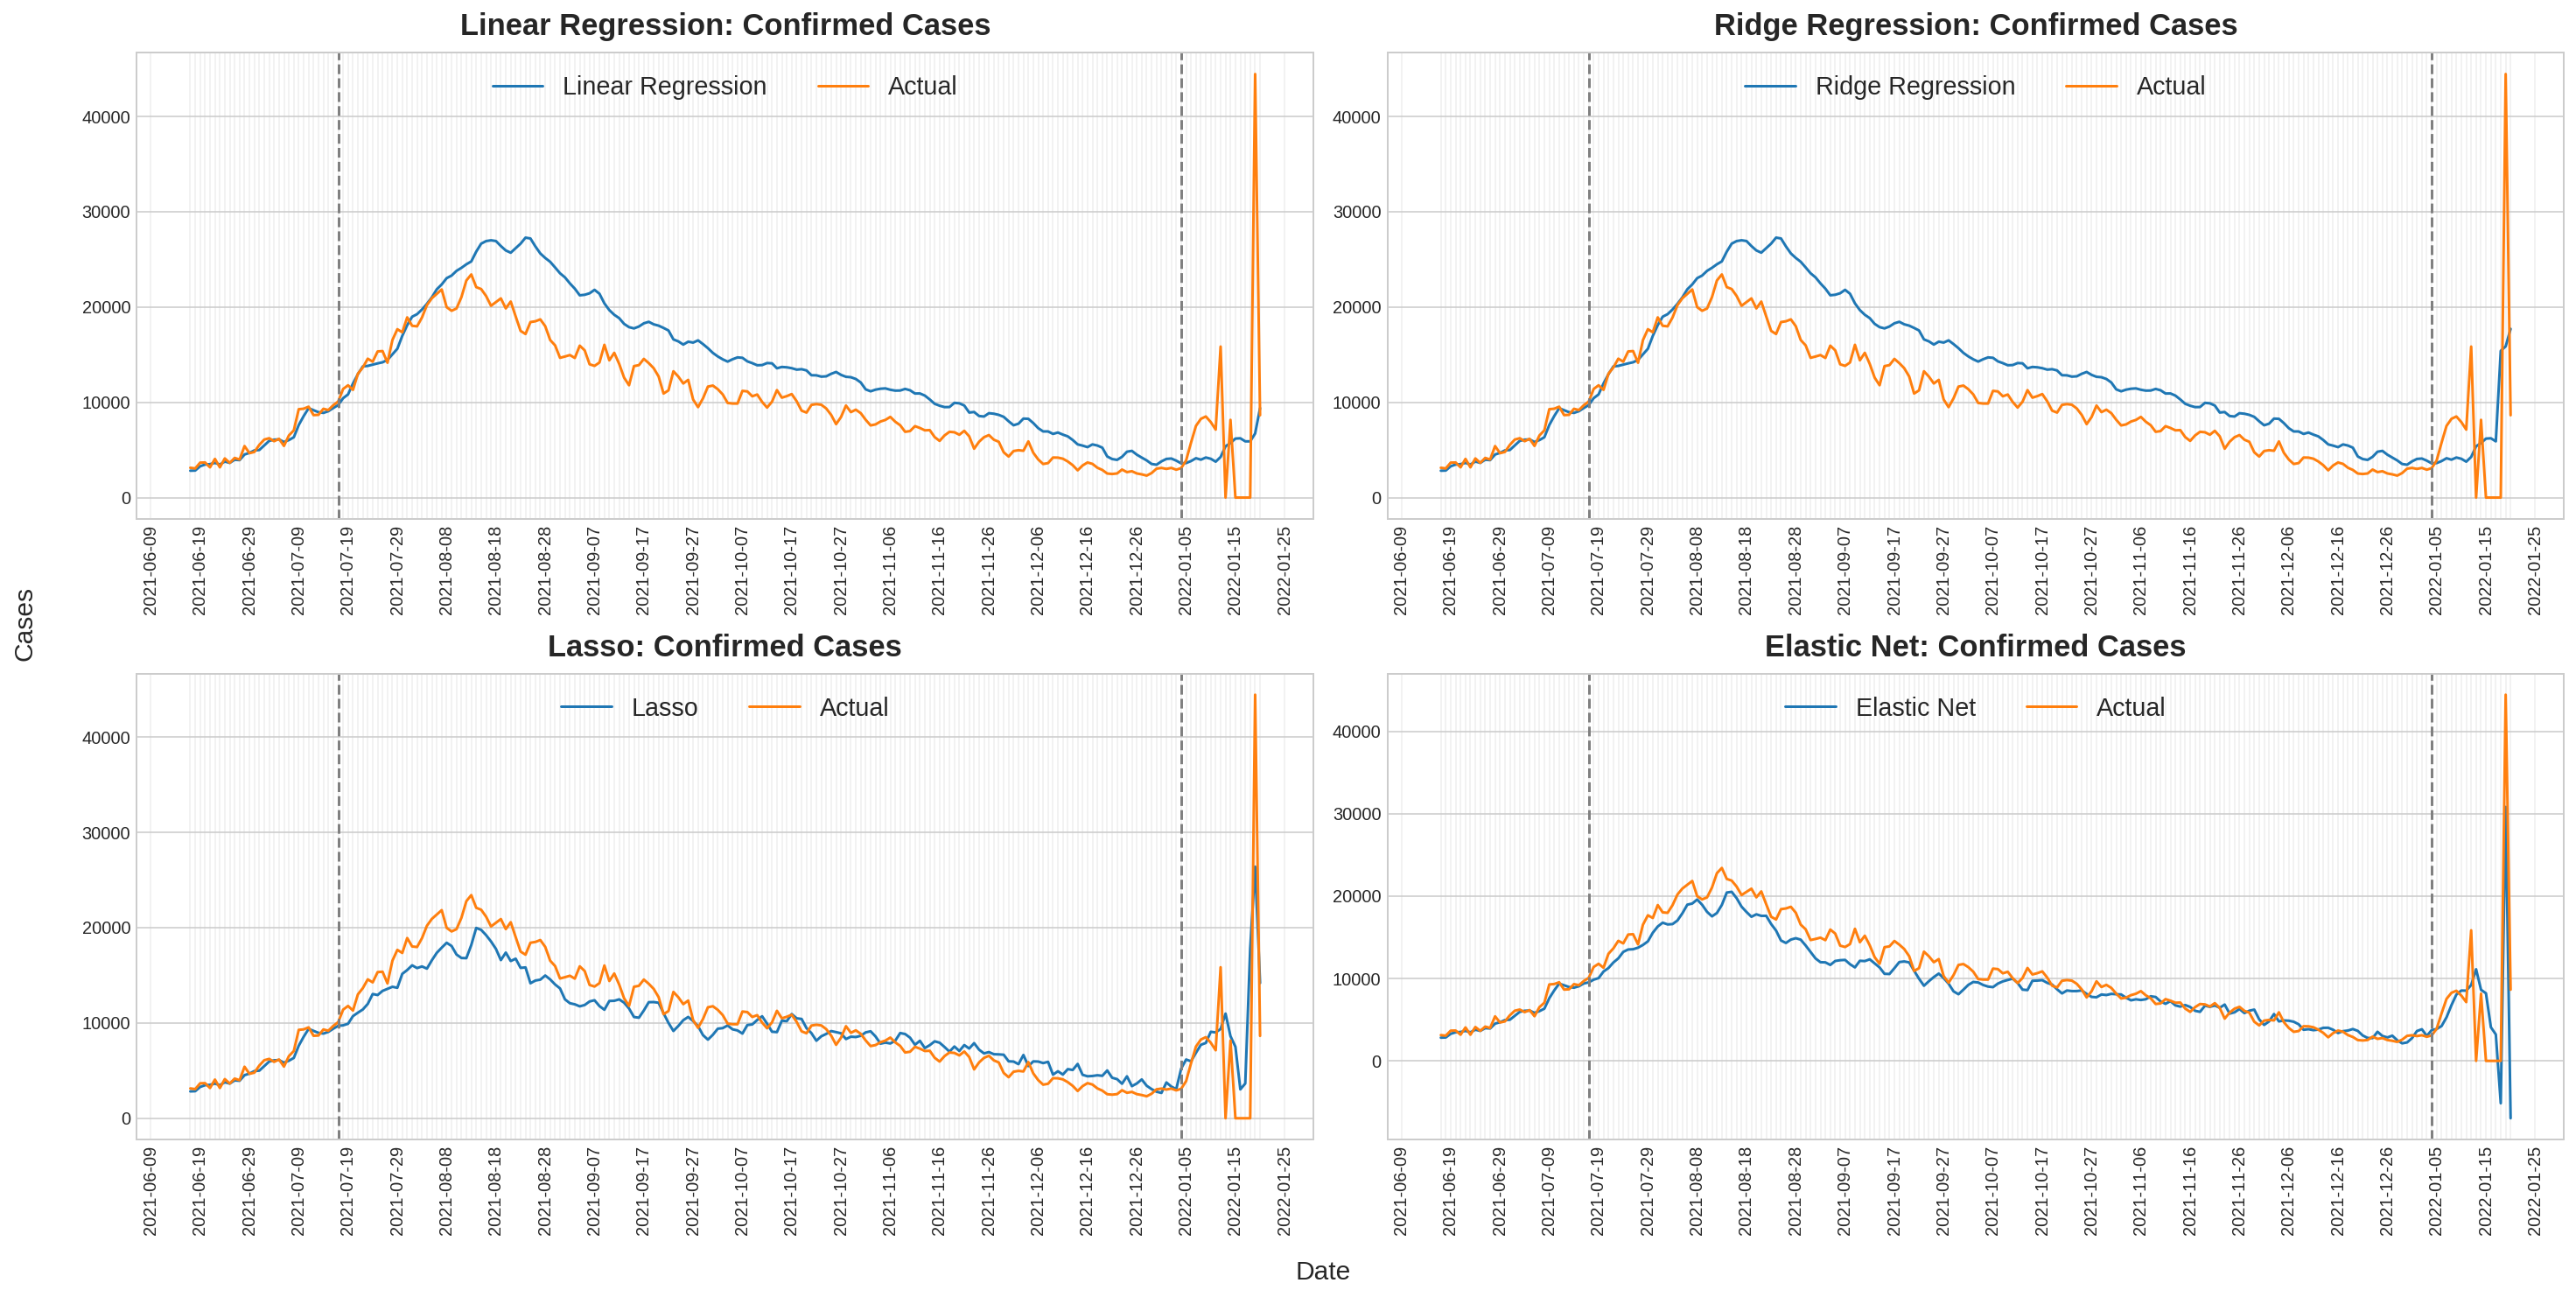

In [ ]:

pred = pd.concat([multi_i_pred_lr, 
                  multi_d_pred_lr,
                  multi_i_pred_rr, 
                  multi_d_pred_rr,
                  multi_i_pred_ls, 
                  multi_d_pred_ls,
                  multi_i_pred_en, 
                  multi_d_pred_en],
                 axis=1)

pred.columns= ['multi_i_pred_lr', 
                  'multi_d_pred_lr',
                  'multi_i_pred_rr', 
                  'multi_d_pred_rr',
                  'multi_i_pred_ls', 
                  'multi_d_pred_ls',
                  'multi_i_pred_en', 
                  'multi_d_pred_en']

# add actual data
act_i = data1.iloc[0+window - 1:].reset_index(drop = True)
act_d = data2.iloc[0+window - 1:].reset_index(drop = True)

pred = pd.concat([pred, act_i.Cases_daily, act_d.Deaths_daily, act_i.Date], axis = 1)

date_test = pred['Date'][0+index]
date_predict = pred['Date'][len(y_total_lr_i)-days_predicted]
tick_spacing = 10

fig, axes = plt.subplots(2, 2, figsize=(20,10)) 
# fig.suptitle("Covid-19 Future Prediction in Thailand", fontsize=20)

axes[0,0].plot(pred['Date'],pred['multi_i_pred_lr'], label = "Linear Regression")
axes[0,0].plot(pred['Date'], pred['Cases_daily'], label = "Actual")
axes[0,0].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
axes[0,0].set_title("Linear Regression: Confirmed Cases", fontsize = 'xx-large')
axes[0,0].tick_params('x',labelrotation=90)
axes[0,0].axvline(date_test, color="gray", linestyle="--")
axes[0,0].axvline(date_predict, color="gray", linestyle="--")
axes[0,0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
axes[0,0].set_xticks(pred['Date'], minor=True)
axes[0,0].xaxis.grid(True, which='both', alpha=0.3)

# ridge
axes[0,1].plot(pred['Date'], pred['multi_i_pred_rr'], label = "Ridge Regression")
axes[0,1].plot(pred['Date'], pred['Cases_daily'], label = "Actual")
axes[0,1].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
axes[0,1].set_title("Ridge Regression: Confirmed Cases", fontsize = 'xx-large')
axes[0,1].tick_params('x',labelrotation=90)
axes[0,1].axvline(date_test, color="gray", linestyle="--")
axes[0,1].axvline(date_predict, color="gray", linestyle="--")
axes[0,1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
axes[0,1].set_xticks(pred['Date'], minor=True)
axes[0,1].xaxis.grid(True, which='both', alpha=0.3)

# lasso
axes[1,0].plot(pred['Date'], pred['multi_i_pred_ls'], label = "Lasso")
axes[1,0].plot(pred['Date'], pred['Cases_daily'], label = "Actual")
axes[1,0].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
axes[1,0].set_title("Lasso: Confirmed Cases", fontsize = 'xx-large')
axes[1,0].tick_params('x',labelrotation=90)
axes[1,0].axvline(date_test, color="gray", linestyle="--")
axes[1,0].axvline(date_predict, color="gray", linestyle="--")
axes[1,0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
axes[1,0].set_xticks(pred['Date'], minor=True)
axes[1,0].xaxis.grid(True, which='both', alpha=0.3)

# elastic net
axes[1,1].plot(pred['Date'], pred['multi_i_pred_en'], label = "Elastic Net")
axes[1,1].plot(pred['Date'], pred['Cases_daily'], label = "Actual")
axes[1,1].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
axes[1,1].set_title("Elastic Net: Confirmed Cases", fontsize = 'xx-large')
axes[1,1].tick_params('x',labelrotation=90)
axes[1,1].axvline(date_test, color="gray", linestyle="--")
axes[1,1].axvline(date_predict, color="gray", linestyle="--")
axes[1,1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
axes[1,1].set_xticks(pred['Date'], minor=True)
axes[1,1].xaxis.grid(True, which='both', alpha=0.3)

fig.text(0.5, -0.02, 'Date', ha='center', fontsize=15)
fig.text(-0.02, 0.5, 'Cases', va='center', rotation='vertical', fontsize=15)
fig.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.9)
plt.show()

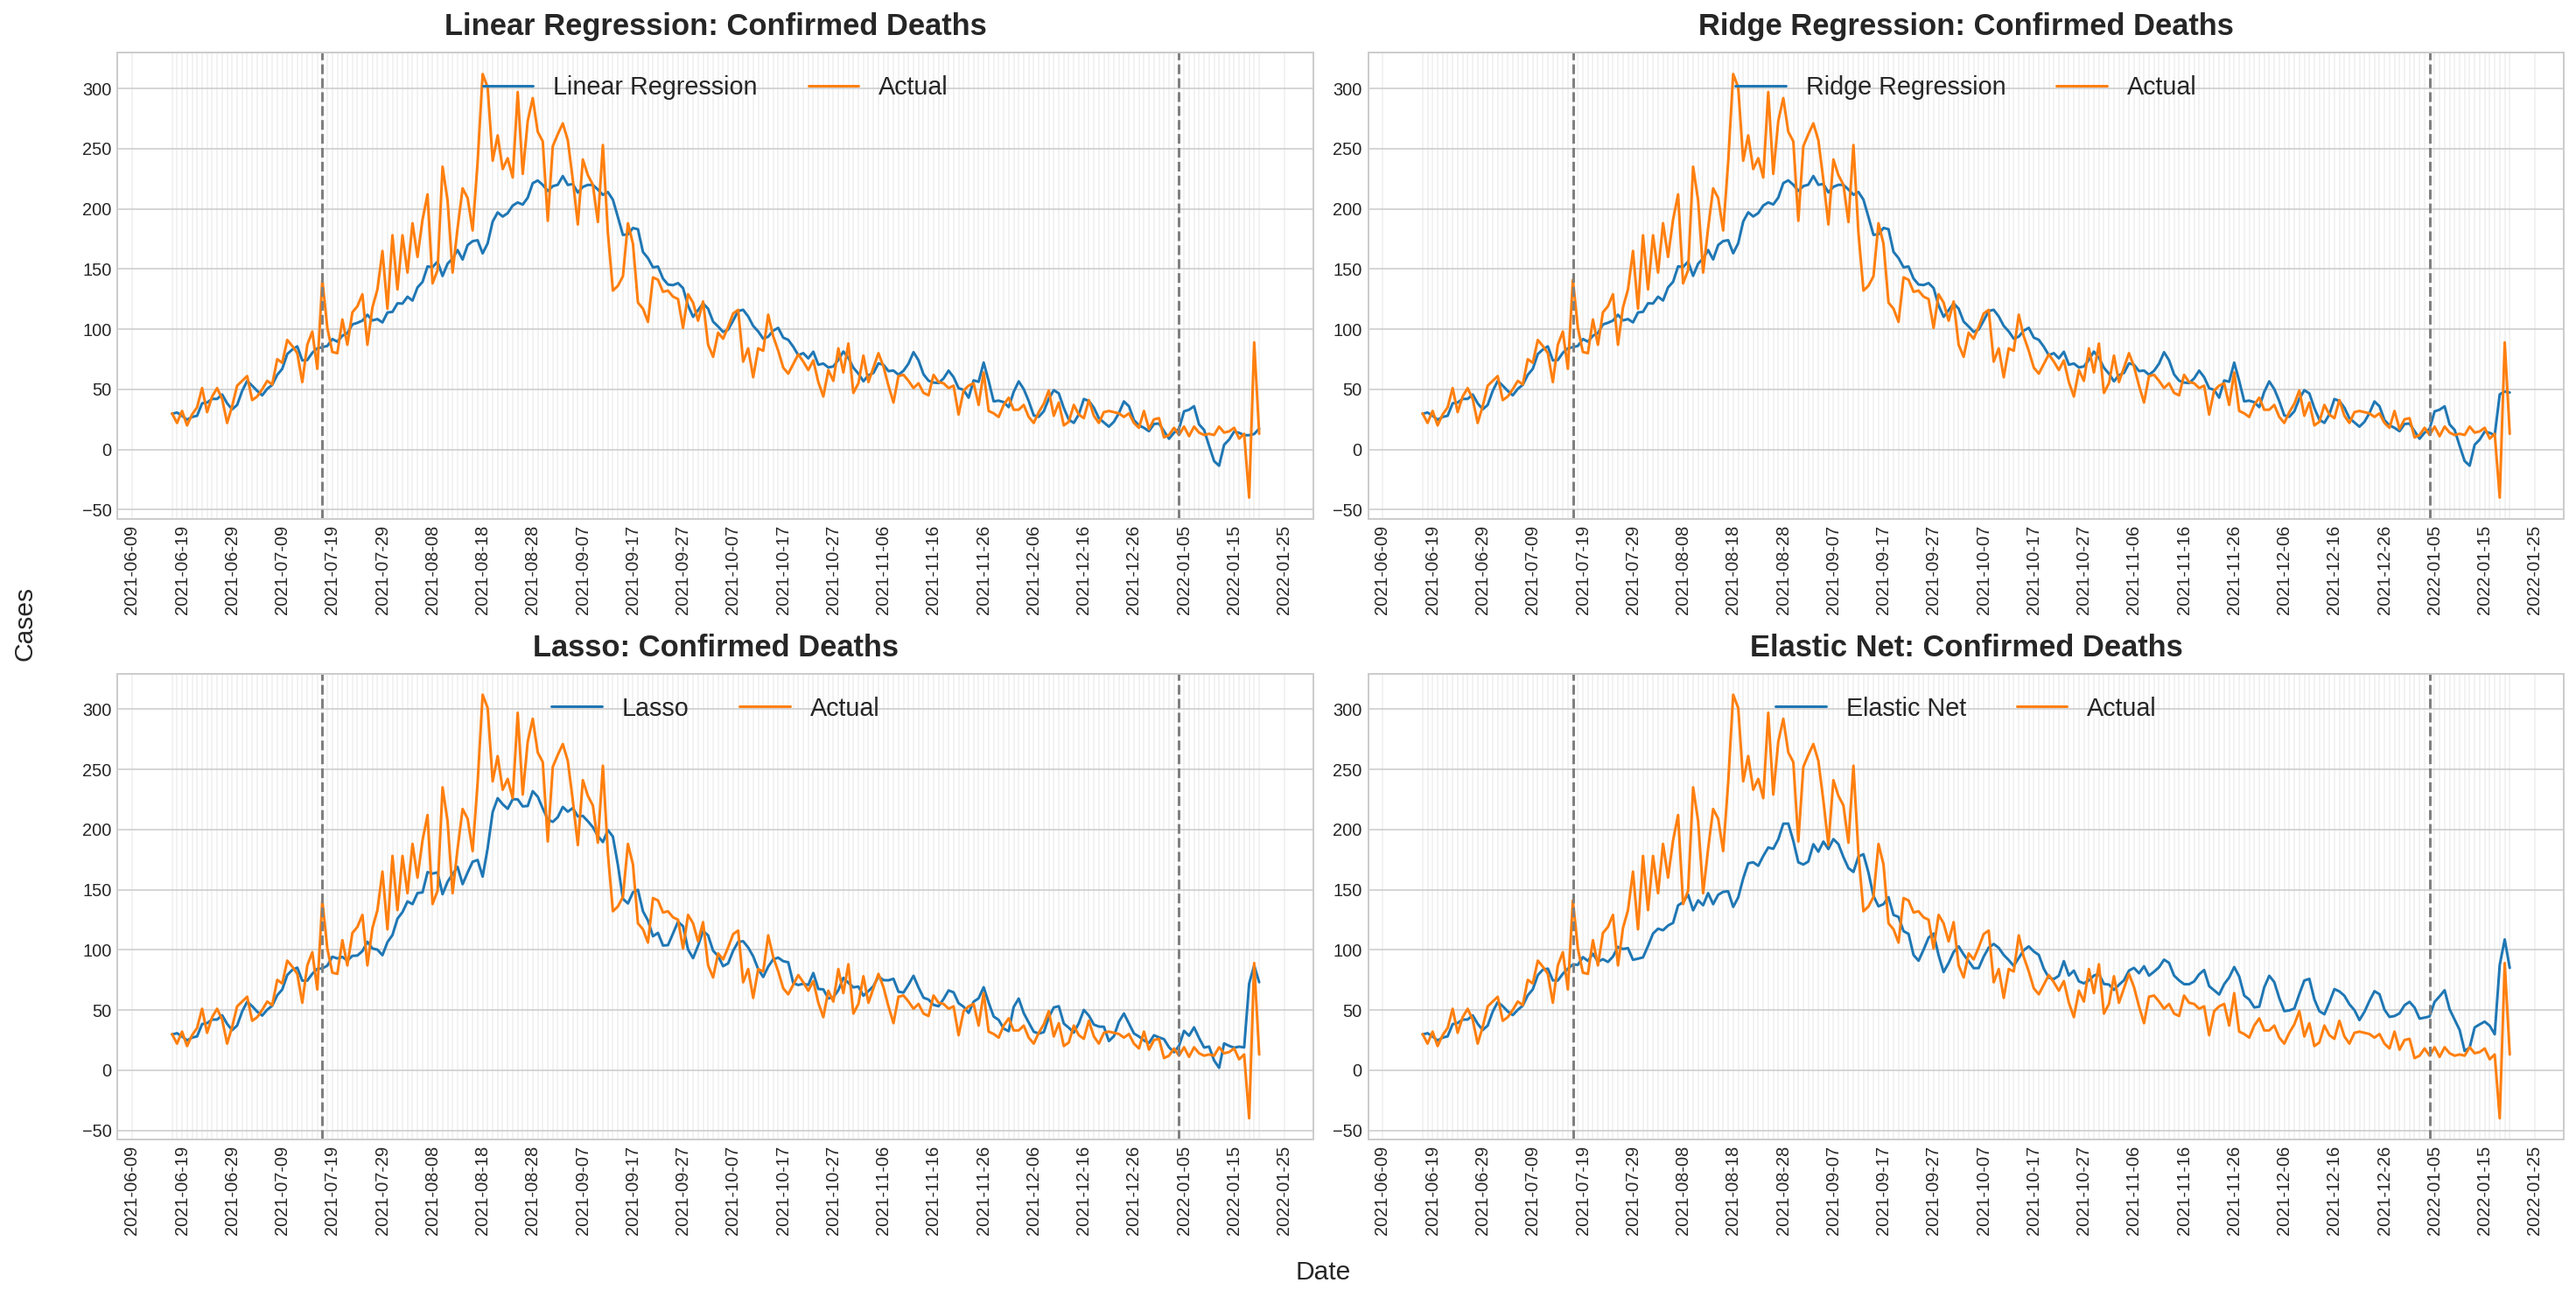

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20,10)) 
# fig.suptitle("Covid-19 Future Prediction in Thailand", fontsize=20)

axes[0,0].plot(pred['Date'],pred['multi_d_pred_lr'], label = "Linear Regression")
axes[0,0].plot(pred['Date'], pred['Deaths_daily'], label = "Actual")
axes[0,0].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
axes[0,0].set_title("Linear Regression: Confirmed Deaths", fontsize = 'xx-large')
axes[0,0].tick_params('x',labelrotation=90)
axes[0,0].axvline(date_test, color="gray", linestyle="--")
axes[0,0].axvline(date_predict, color="gray", linestyle="--")
axes[0,0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
axes[0,0].set_xticks(pred['Date'], minor=True)
axes[0,0].xaxis.grid(True, which='both', alpha=0.3)

# ridge
axes[0,1].plot(pred['Date'], pred['multi_d_pred_rr'], label = "Ridge Regression")
axes[0,1].plot(pred['Date'], pred['Deaths_daily'], label = "Actual")
axes[0,1].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
axes[0,1].set_title("Ridge Regression: Confirmed Deaths", fontsize = 'xx-large')
axes[0,1].tick_params('x',labelrotation=90)
axes[0,1].axvline(date_test, color="gray", linestyle="--")
axes[0,1].axvline(date_predict, color="gray", linestyle="--")
axes[0,1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
axes[0,1].set_xticks(pred['Date'], minor=True)
axes[0,1].xaxis.grid(True, which='both', alpha=0.3)

# lasso
axes[1,0].plot(pred['Date'], pred['multi_d_pred_ls'], label = "Lasso")
axes[1,0].plot(pred['Date'], pred['Deaths_daily'], label = "Actual")
axes[1,0].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
axes[1,0].set_title("Lasso: Confirmed Deaths", fontsize = 'xx-large')
axes[1,0].tick_params('x',labelrotation=90)
axes[1,0].axvline(date_test, color="gray", linestyle="--")
axes[1,0].axvline(date_predict, color="gray", linestyle="--")
axes[1,0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
axes[1,0].set_xticks(pred['Date'], minor=True)
axes[1,0].xaxis.grid(True, which='both', alpha=0.3)

# elastic net
axes[1,1].plot(pred['Date'], pred['multi_d_pred_en'], label = "Elastic Net")
axes[1,1].plot(pred['Date'], pred['Deaths_daily'], label = "Actual")
axes[1,1].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
axes[1,1].set_title("Elastic Net: Confirmed Deaths", fontsize = 'xx-large')
axes[1,1].tick_params('x',labelrotation=90)
axes[1,1].axvline(date_test, color="gray", linestyle="--")
axes[1,1].axvline(date_predict, color="gray", linestyle="--")
axes[1,1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
axes[1,1].set_xticks(pred['Date'], minor=True)
axes[1,1].xaxis.grid(True, which='both', alpha=0.3)

fig.text(0.5, -0.02, 'Date', ha='center', fontsize=15)
fig.text(-0.02, 0.5, 'Cases', va='center', rotation='vertical', fontsize=15)
fig.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.9)
plt.show()

Overall, we can see that all models for future predictions performed worse on the last two days. This might imply limitation of the machine learning models. This method might be suitable for few days of future predictions. 

Predicting infected cases was not at all accurated though having the same trends as the actual values. Future research should try with a different training set, to see if the accuracy of future prediction can be improved.